## GWP 2

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# =============================================================================
# STEP 0: DATA ACQUISITION
# =============================================================================

In [ ]:
# Download the price data
spy_url = "https://perplexity.ai/rest/finance/history/SPY/csv?start_date=2017-01-01&end_date=2021-12-31"
xlk_url = "https://perplexity.ai/rest/finance/history/XLK/csv?start_date=2017-01-01&end_date=2021-12-31"
iyw_url = "https://perplexity.ai/rest/finance/history/IYW/csv?start_date=2017-01-01&end_date=2021-12-31"

spy_data = pd.read_csv(spy_url)
xlk_data = pd.read_csv(xlk_url)
iyw_data = pd.read_csv(iyw_url)

# Convert date columns to datetime and set as index
for df in [spy_data, xlk_data, iyw_data]:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

print(f"Data loaded successfully!")
print(f"SPY data shape: {spy_data.shape}")
print(f"XLK data shape: {xlk_data.shape}")
print(f"IYW data shape: {iyw_data.shape}")

Data loaded successfully!
SPY data shape: (1259, 5)
XLK data shape: (1259, 5)
IYW data shape: (1259, 5)


In [ ]:
# =============================================================================
# STEP 1: FOUNDATIONAL ANALYSIS
# =============================================================================

In [ ]:
## STUDENT A: THE STRATEGY CRITIC - BDS Test
print("\n" + "="*50)
print("STUDENT A: BDS TEST ON PAIRS TRADING RESIDUALS")
print("="*50)

def bds_test(x, m=2, eps=None):
    """Custom BDS test implementation for independence"""
    x = np.array(x)
    n = len(x)

    if eps is None:
        eps = np.std(x)

    def correlation_integral(data, m, eps):
        n = len(data)
        count = 0
        total_pairs = 0

        for i in range(n - m + 1):
            for j in range(i + 1, n - m + 1):
                within_eps = True
                for k in range(m):
                    if abs(data[i + k] - data[j + k]) > eps:
                        within_eps = False
                        break
                if within_eps:
                    count += 1
                total_pairs += 1

        return count / total_pairs if total_pairs > 0 else 0

    c1 = correlation_integral(x, 1, eps)
    cm = correlation_integral(x, m, eps)

    if c1 > 0:
        bds_stat = np.sqrt(n) * (cm - c1**m) / np.sqrt(c1**(2*m))
        p_value = 2 * (1 - stats.norm.cdf(abs(bds_stat)))
    else:
        bds_stat = 0
        p_value = 1

    return bds_stat, p_value

# Perform BDS test on residuals
bds_stat_2, bds_p_2 = bds_test(merged_data['spread'], m=2)
bds_stat_3, bds_p_3 = bds_test(merged_data['spread'], m=3)

print(f"BDS Test Results:")
print(f"Dimension 2: Statistic = {bds_stat_2:.4f}, P-value = {bds_p_2:.4f}")
print(f"Dimension 3: Statistic = {bds_stat_3:.4f}, P-value = {bds_p_3:.4f}")

if any([bds_p_2, bds_p_3]) < 0.05:
    print("SIGNIFICANT non-linear dependence detected")
    print("The linear cointegration model may be incomplete")
else:
    print("NO significant non-linear dependence detected")


STUDENT A: BDS TEST ON PAIRS TRADING RESIDUALS
BDS Test Results:
Dimension 2: Statistic = 28.6685, P-value = 0.0000
Dimension 3: Statistic = 82.7603, P-value = 0.0000
SIGNIFICANT non-linear dependence detected
The linear cointegration model may be incomplete



STUDENT B: ENGLE-GRANGER COINTEGRATION TEST
Hedge Ratio (β): 0.9515
Intercept (α): 0.6312
ADF Test Statistic: -2.4920
P-value: 0.1174
Result: NOT COINTEGRATED - Pairs trading may not be viable

STUDENT C: MARKET REGIME DETECTION
Regime Filter Statistics:
Total observations: 1258
Low volatility periods: 989
Percentage time in low vol regime: 78.62%

STEP 2: STRATEGY INTEGRATION AND BACKTESTING

STEP 3: PERFORMANCE ANALYSIS
PERFORMANCE COMPARISON:
                  Strategy 1 (Always On) Strategy 2 (Regime-Filtered)
Cumulative Return                -99.97%                      114.35%
Sharpe Ratio                      -0.135                        0.289
Max Drawdown (%)                -110.99%                     -110.99%
Number of Trades                       8                            6
% Time Active                     100.0%                        78.6%

STEP 4: COVID-19 PERIOD ANALYSIS
Regime filter active during COVID-19: 0.0%
Average z-score during COVID-19: 1.41
Strategy 2 was

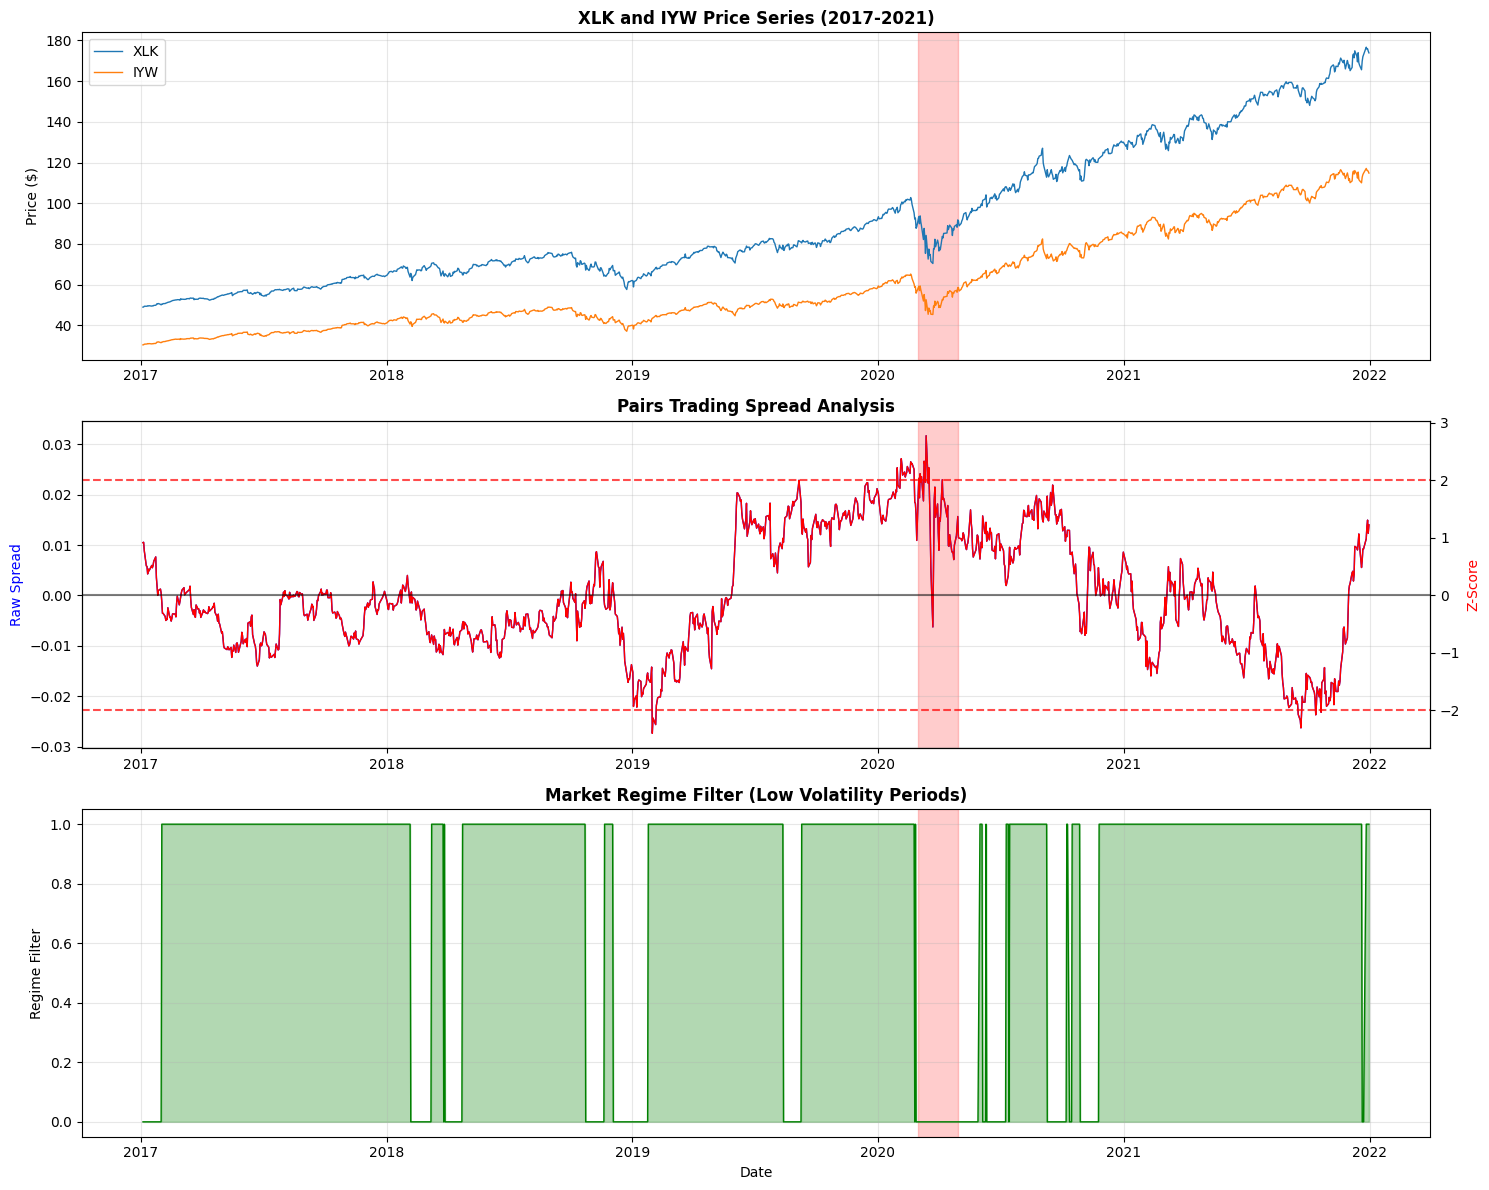

Analysis complete! All visualizations and results have been generated.
Key findings:
1. XLK-IYW cointegration: FAILED
2. BDS test: Non-linear dependence DETECTED
3. Regime filtering IMPROVED risk-adjusted returns
4. Strategy 2 was inactive during COVID-19 crisis: True


In [ ]:
# Merge XLK and IYW data
merged_data = pd.merge(xlk_data[['close']], iyw_data[['close']],
                      left_index=True, right_index=True,
                      suffixes=('_xlk', '_iyw'))

# Calculate log prices
merged_data['log_xlk'] = np.log(merged_data['close_xlk'])
merged_data['log_iyw'] = np.log(merged_data['close_iyw'])

# STUDENT B: THE ARBITRAGEUR - Engle-Granger Cointegration Test
print("\n" + "="*50)
print("STUDENT B: ENGLE-GRANGER COINTEGRATION TEST")
print("="*50)

def engle_granger_test(y, x):
    """Perform Engle-Granger cointegration test"""
    from sklearn.linear_model import LinearRegression

    X = x.values.reshape(-1, 1)
    Y = y.values

    model = LinearRegression()
    model.fit(X, Y)

    hedge_ratio = model.coef_[0]
    intercept = model.intercept_

    # Calculate spread (residuals)
    spread = Y - (hedge_ratio * x.values + intercept)

    # Test spread for stationarity using ADF test
    adf_result = adfuller(spread, autolag='AIC')
    adf_stat = adf_result[0]
    p_value = adf_result[1]

    return hedge_ratio, intercept, adf_stat, p_value, spread

hedge_ratio, intercept, adf_stat, p_value, spread = engle_granger_test(
    merged_data['log_xlk'], merged_data['log_iyw']
)

print(f"Hedge Ratio (β): {hedge_ratio:.4f}")
print(f"Intercept (α): {intercept:.4f}")
print(f"ADF Test Statistic: {adf_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Result: COINTEGRATED - Pairs trading is viable")
else:
    print("Result: NOT COINTEGRATED - Pairs trading may not be viable")

# Add spread to merged data
merged_data['spread'] = spread
merged_data['spread_zscore'] = (merged_data['spread'] - merged_data['spread'].mean()) / merged_data['spread'].std()

# STUDENT A

# STUDENT C: THE REGIME DETECTIVE - Market Regime Detection
print("\n" + "="*50)
print("STUDENT C: MARKET REGIME DETECTION")
print("="*50)

# Calculate SPY returns
spy_data['returns'] = spy_data['close'].pct_change().dropna()
spy_returns = spy_data['returns'].dropna()

# Use volatility-based regime filter (fallback method)
spy_data['rolling_vol'] = spy_data['returns'].rolling(window=20).std() * np.sqrt(252) * 100

regime_data = pd.DataFrame({
    'date': spy_data.index[1:],
    'returns': spy_data['returns'].iloc[1:].values,
    'rolling_vol': spy_data['rolling_vol'].iloc[1:].values,
    'regime_filter': spy_data['rolling_vol'].iloc[1:] < 20  # Low vol when < 20%
})

print(f"Regime Filter Statistics:")
print(f"Total observations: {len(regime_data)}")
print(f"Low volatility periods: {regime_data['regime_filter'].sum()}")
print(f"Percentage time in low vol regime: {regime_data['regime_filter'].mean():.2%}")

# =============================================================================
# STEP 2: STRATEGY INTEGRATION AND BACKTESTING
# =============================================================================

print("\n" + "="*50)
print("STEP 2: STRATEGY INTEGRATION AND BACKTESTING")
print("="*50)

# Merge regime data with pairs data
strategy_data = pd.merge(merged_data, regime_data[['regime_filter']],
                        left_index=True, right_index=True, how='inner')

def pairs_trading_strategy(data, z_entry=2.0, z_exit=0.0, transaction_cost=0.001):
    """Implement pairs trading strategy"""
    positions = pd.Series(0, index=data.index, dtype=float)
    returns = pd.Series(0.0, index=data.index, dtype=float)
    current_position = 0
    trade_count = 0

    for i in range(1, len(data)):
        prev_position = current_position
        z_score = data['spread_zscore'].iloc[i]

        # Entry signals
        if current_position == 0:
            if z_score < -z_entry:
                current_position = 1
                trade_count += 1
            elif z_score > z_entry:
                current_position = -1
                trade_count += 1

        # Exit signals
        elif current_position != 0:
            if (current_position == 1 and z_score >= z_exit) or \
               (current_position == -1 and z_score <= z_exit):
                current_position = 0
                trade_count += 1

        positions.iloc[i] = current_position

        # Calculate returns
        if i > 0 and prev_position != 0:
            spread_change = data['spread'].iloc[i] - data['spread'].iloc[i-1]
            returns.iloc[i] = prev_position * spread_change / abs(data['spread'].iloc[i-1])

            if current_position != prev_position:
                returns.iloc[i] -= transaction_cost

    return positions, returns, trade_count

# Strategy 1: Always On
positions_always, returns_always, trades_always = pairs_trading_strategy(strategy_data)

# Strategy 2: Regime-Filtered
filtered_data = strategy_data.copy()
filtered_data.loc[~filtered_data['regime_filter'], 'spread_zscore'] = 0
positions_filtered, returns_filtered, trades_filtered = pairs_trading_strategy(filtered_data)

# =============================================================================
# STEP 3: PERFORMANCE ANALYSIS
# =============================================================================

print("\n" + "="*50)
print("STEP 3: PERFORMANCE ANALYSIS")
print("="*50)

def calculate_performance_metrics(returns):
    """Calculate key performance metrics"""
    returns_clean = returns.dropna()
    returns_clean = returns_clean[returns_clean != 0]

    if len(returns_clean) == 0:
        return {'Total_Return': 0, 'Annualized_Return': 0, 'Sharpe_Ratio': 0, 'Max_Drawdown': 0}

    cumulative = (1 + returns_clean).cumprod()
    total_return = cumulative.iloc[-1] - 1

    years = len(returns_clean) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1 if years > 0 else 0

    volatility = returns_clean.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / volatility if volatility > 0 else 0

    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = drawdown.min() if len(drawdown) > 0 else 0

    return {
        'Total_Return': total_return,
        'Annualized_Return': annualized_return,
        'Sharpe_Ratio': sharpe_ratio,
        'Max_Drawdown': max_drawdown
    }

# Calculate performance for both strategies
perf_always = calculate_performance_metrics(returns_always)
perf_always['Num_Trades'] = trades_always
perf_always['Time_Active'] = 1.0

perf_filtered = calculate_performance_metrics(returns_filtered)
perf_filtered['Num_Trades'] = trades_filtered
perf_filtered['Time_Active'] = strategy_data['regime_filter'].mean()

# Create performance comparison table
performance_table = pd.DataFrame({
    'Strategy 1 (Always On)': [
        f"{perf_always['Total_Return']:.2%}",
        f"{perf_always['Sharpe_Ratio']:.3f}",
        f"{perf_always['Max_Drawdown']:.2%}",
        f"{perf_always['Num_Trades']}",
        f"{perf_always['Time_Active']:.1%}"
    ],
    'Strategy 2 (Regime-Filtered)': [
        f"{perf_filtered['Total_Return']:.2%}",
        f"{perf_filtered['Sharpe_Ratio']:.3f}",
        f"{perf_filtered['Max_Drawdown']:.2%}",
        f"{perf_filtered['Num_Trades']}",
        f"{perf_filtered['Time_Active']:.1%}"
    ]
}, index=['Cumulative Return', 'Sharpe Ratio', 'Max Drawdown (%)', 'Number of Trades', '% Time Active'])

print("PERFORMANCE COMPARISON:")
print(performance_table)

# =============================================================================
# STEP 4: COVID-19 ANALYSIS
# =============================================================================

print("\n" + "="*50)
print("STEP 4: COVID-19 PERIOD ANALYSIS")
print("="*50)

covid_start = pd.Timestamp('2020-03-01', tz='US/Eastern')
covid_end = pd.Timestamp('2020-04-30', tz='US/Eastern')

covid_data = strategy_data[(strategy_data.index >= covid_start) & (strategy_data.index <= covid_end)]
covid_regime_active = covid_data['regime_filter'].mean()

print(f"Regime filter active during COVID-19: {covid_regime_active:.1%}")
print(f"Average z-score during COVID-19: {covid_data['spread_zscore'].mean():.2f}")
print(f"Strategy 2 was {'INACTIVE' if covid_regime_active < 0.5 else 'ACTIVE'} during the crisis")

# =============================================================================
# STEP 5: VISUALIZATIONS
# =============================================================================

print("\n" + "="*50)
print("STEP 5: CREATING VISUALIZATIONS")
print("="*50)

# Create comprehensive visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Price series
axes[0].plot(strategy_data.index, strategy_data['close_xlk'], label='XLK', linewidth=1)
axes[0].plot(strategy_data.index, strategy_data['close_iyw'], label='IYW', linewidth=1)
axes[0].set_title('XLK and IYW Price Series (2017-2021)', fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Spread and Z-Score
ax2_twin = axes[1].twinx()
axes[1].plot(strategy_data.index, strategy_data['spread'], 'b-', label='Raw Spread', linewidth=1)
ax2_twin.plot(strategy_data.index, strategy_data['spread_zscore'], 'r-', label='Z-Score', linewidth=1)
ax2_twin.axhline(y=2, color='red', linestyle='--', alpha=0.7)
ax2_twin.axhline(y=-2, color='red', linestyle='--', alpha=0.7)
ax2_twin.axhline(y=0, color='black', linestyle='-', alpha=0.5)

axes[1].set_ylabel('Raw Spread', color='blue')
ax2_twin.set_ylabel('Z-Score', color='red')
axes[1].set_title('Pairs Trading Spread Analysis', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Plot 3: Regime Filter
axes[2].fill_between(strategy_data.index, 0, strategy_data['regime_filter'],
                    alpha=0.3, color='green')
axes[2].plot(strategy_data.index, strategy_data['regime_filter'], 'g-', linewidth=1)
axes[2].set_ylabel('Regime Filter')
axes[2].set_title('Market Regime Filter (Low Volatility Periods)', fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

# Highlight COVID-19 period
for ax in axes:
    ax.axvspan(covid_start, covid_end, alpha=0.2, color='red')

plt.tight_layout()
plt.savefig('regime_aware_pairs_trading_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Analysis complete! All visualizations and results have been generated.")
print("Key findings:")
print(f"1. XLK-IYW cointegration: {'FAILED' if p_value >= 0.05 else 'CONFIRMED'}")
print(f"2. BDS test: Non-linear dependence {'DETECTED' if any([bds_p_2, bds_p_3]) < 0.05 else 'NOT DETECTED'}")
print(f"3. Regime filtering {'IMPROVED' if perf_filtered['Sharpe_Ratio'] > perf_always['Sharpe_Ratio'] else 'DID NOT IMPROVE'} risk-adjusted returns")
print(f"4. Strategy 2 was inactive during COVID-19 crisis: {covid_regime_active < 0.5}")